In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scipy.stats as stats
import time
np.random.seed(0)
file='final_results_2'

In [2]:
@jit
def binary_(n, num_QS):
    """Converts a decimal number to binary with length num_QS"""
    bin_str=np.zeros(num_QS, dtype=np.int64)
    if n == 0:
        return bin_str
    i=0
    while n > 0:
        bin_str[i] = n % 2
        n //= 2
        i = i+1
    return np.flip(bin_str)

In [3]:
@jit
def decimal_(bin_str, num_QS):
    """Converts a binary number to decimal with length num_QS"""

    bin_str=np.flip(bin_str)
    n=0
    for ii in range(num_QS):
        n = n+(2**ii)*bin_str[ii]
    return np.int_(n)

In [4]:
@jit
def row_column(qsn,beta0,num_strains,center,beta_s,p,NN_max,alpha):
    "Reasigns an interaction coefficient related to species number qsn in the"
    "initial interaction matrix beta0 of size num_strainsxnum_strains. Coefficients are"
    "taken from a gaussian distribution of mean 0 and standard deviation beta_s."
    "p is the replacement probability."
    "beta_prime is the matrix with modified coefficients"
    
    beta_prime=np.copy(beta0)
    
    for j in range(num_strains+1):
        if np.random.rand() <= p:
            beta_prime[qsn,j] = np.random.normal(loc=center, scale=beta_s)
    for k in range(num_strains+1):
        if np.random.rand() <= p:
            beta_prime[k,qsn] = np.random.normal(loc=center, scale=beta_s)

    return beta_prime

In [5]:
@jit
def interact_matrices(num_strains,center,beta_s,num_QS,alpha,NN_max): 
    "Defines the interaction matrices for each QS activity state."
    "center is the mean of a guassian distribution for interaction coefficients and beta_s its standrd deviation."
    "num_QS is the number of QS species in the community. alpha is the growth rate constant and NN_max the carrying capacity."
    "Beta is an array that contains all the interaction matrices. qs_s contains the index of each QS species."
    
    qs_s=np.arange(num_QS+1).astype(np.int64) 
    qs_s=np.delete(qs_s,1)

    p=0.3        #Probability with each QS strain affecs or is affected by the other strains

    beta = np.zeros((2**num_QS,num_strains+1,num_strains+1))

    beta[0] = np.random.normal(center, beta_s, (num_strains+1, num_strains+1))     #Beta with random entrees

    beta[0][1,:] = np.copy(beta[0][0,:])
    beta[0][:,1] = np.copy(beta[0][:,0])  #cheaters interact equally with the other strains at low densities

    beta[0][1,0] = -alpha[0]/(NN_max)
    beta[0][0,1] = -alpha[1]/(NN_max) #The QS strain doesn't interact with its daugther mutants at low densities (only saturation effects)

    for ll in range(num_strains+1):
        beta[0][ll,ll]=-alpha[ll]/NN_max

    beta[0][0,0] = beta[0][0,0] 
    beta[0][1,1] = beta[0][1,1] 
    
    ind_QS=np.zeros(num_QS, dtype=np.int64)

    for ii in range(num_QS):
        #Define int matrices for single QS species activation
        binary=np.zeros(num_QS, dtype=np.int64)
        binary[ii]=1
        binary=np.flip(binary)
        ind=decimal_(binary,num_QS)
        ind_QS[ii]=ind
        beta0=np.copy(beta[0])
        nqs=qs_s[ii]
        beta[ind]=row_column(nqs,beta0,num_strains,center,beta_s,p,NN_max,alpha) #replace few terms of row and collumn
                                                                                 #nqs of the low density interaction matrix 

        beta[ind][1,:] = np.copy(beta[0][0,:])
        beta[ind][:,1] = np.copy(beta[0][:,0])

        beta[ind][1,0] = -alpha[0]/(NN_max)
        beta[ind][0,1] = -alpha[1]/(NN_max) #The QS strain doesn't interact with its daugther mutants at low densities (only saturation effects)

        for ll in range(num_strains+1):
            beta[ind][ll,ll]=-alpha[ll]/NN_max

        beta[ind][0,0] = beta[0][0,0]
        beta[ind][1,1] = beta[0][1,1] 

    for ii in range(2**num_QS-1):
        #Define matrices with more than one QS species active
        #Previous defined matrices copy themselfs, so they remain unchanged
        binary=np.flip(binary_(ii+1, num_QS))
        nqs=qs_s[binary==1]
        nind=ind_QS[binary==1]
        beta22=np.copy(beta[0])
        for jj in range(len(nind)):
            ind=nind[jj]
            ind_qs=nqs[jj]
            beta11=np.copy(beta[ind])   
            for k in range(num_strains+1):
                beta22[ind_qs,k]=beta11[ind_qs,k]
                beta22[k,ind_qs]=beta11[k,ind_qs]
        for k1 in nqs:
            for k2 in nqs:
                if np.random.rand() <= p:
                    beta22[k1,k2]=np.random.normal(loc=center, scale=beta_s)
        
        beta[ii+1]=beta22
        beta[ii+1][1,:] = np.copy(beta[0][0,:])
        beta[ii+1][:,1] = np.copy(beta[0][:,0])
        beta[ii+1][1,0] = -alpha[0]/(NN_max)
        beta[ii+1][0,1] = -alpha[1]/(NN_max) #The QS strain doesn't interact with its daugther mutants at low densities (only saturation effects)
        for ll in range(num_strains+1):
            beta[ii+1][ll,ll]=-alpha[ll]/NN_max
        beta[ii+1][0,0] = beta[0][0,0] 
        beta[ii+1][1,1] = beta[0][1,1]

    return beta, qs_s

In [6]:
@jit
def ff_i(t,i,alpha,beta1_,yy):
    "Lotka-Volterra equations"
    return yy[i]*(alpha[i]+(beta1_ @ yy)[i])

In [7]:
@jit
def reseed(N,N_max,reseed_num,num_strains,x):
    "Reseeding of cells."
    "N are the population densities, N_max the maximum total cell density, reseed_num the density after the transfer,"
    "and x the time control."
    
    total_density = np.sum(N)
    N_2=N.copy()
    y=False
    
    if total_density > N_max:

        fractions_r=np.empty(num_strains).astype(np.float64)

        for k in range(num_strains):
            fractions_r[k] = N_2[k] / total_density

        #Bins induced by the fractions of the species.
        cumulative_fractions=np.zeros(num_strains+1)

        cs=0
        for k in range(num_strains):
            cs=cs+fractions_r[k]
            cumulative_fractions[k+1]=cs
        
        #generate random numbers
        cell_partition=np.zeros(reseed_num).astype(np.float64)
        for k in range(reseed_num):
            cell_partition[k]=np.random.random_sample()
            
        #Finding the new_N. Histogram counts the number of cells in each bin.
        new_N, bins = np.histogram(cell_partition, bins=cumulative_fractions)
        y=True

        new_N=new_N.astype(np.float64)
        
        return new_N, True
    
    if x:
        
        fractions_r=np.empty(num_strains).astype(np.float64)

        for k in range(num_strains):
            fractions_r[k] = N_2[k] / total_density

        #Bins induced by the fractions of the species.
        cumulative_fractions=np.zeros(num_strains+1)

        cs=0
        for k in range(num_strains):
            cs=cs+fractions_r[k]
            cumulative_fractions[k+1]=cs
        
        #generate random numbers
        cell_partition=np.zeros(reseed_num).astype(np.float64)
        for k in range(reseed_num):
            cell_partition[k]=np.random.random_sample()
                    
        #Finding the new_N. Histogram counts the number of cells in each bin.
        new_N, bins = np.histogram(cell_partition, bins=cumulative_fractions)
        y=True

        new_N=new_N.astype(np.float64)
        
        return new_N, True
    
    return N, y

In [8]:
@jit
def RK4_GLVQS(N_initial,N_critical,N_max,num_strains,alpha,beta,reseed_number,target_reseeds,qs_list):
    "Runge-Kutta order 4 numerical solver modified to capture the QS activity state and cells tranfers."
    "frac contains the fraction of each population at each cells transfer."
    "survv contains the number of survivors at each cells transfer."
    
    reseed_count = 0
    hh=0.005                                             #time step
    tt=0.0                                                 #Initial time
    time_con=0.
    
    num_QS=len(qs_list)
    qs_act=np.zeros(num_QS)
    
    NN=N_initial.copy()
    ww2=np.zeros(num_strains+1)                              #Auxiliars to RK4 
    ww3=np.zeros(num_strains+1)
    ww4=np.zeros(num_strains+1)
    kk1=np.zeros(num_strains+1)
    kk2=np.zeros(num_strains+1)
    kk3=np.zeros(num_strains+1)
    kk4=np.zeros(num_strains+1)
    
    frac=np.zeros((target_reseeds+1,num_strains+1))
    for k in range(len(NN)):
        frac[0,k]=NN[k]/np.sum(NN)
    
    alpha_cost=np.copy(alpha)
                
    while reseed_count < target_reseeds:    
    #RK4 method
        
        x=False

        for i1 in range(num_QS):
            ind=qs_list[i1]
            if NN[ind]>N_critical[ind]:
                qs_act[i1]=1
            else:
                qs_act[i1]=0
                
        beta_ind=decimal_(np.flip(qs_act), num_QS)

        beta11=np.copy(beta[beta_ind])
        
        for j in range(num_strains+1):
            aa=ff_i(tt,j,alpha_cost,beta11,NN)
            kk1[j]=hh*aa
            bb=NN[j]
            ww2[j]=bb+(0.5*hh*aa)
        for j in range(num_strains+1):
            aa=ff_i(tt+(hh/2),j,alpha_cost,beta11,ww2)
            kk2[j]=hh*aa
            bb=NN[j]
            ww3[j]=bb+(0.5*hh*aa)
        for j in range(num_strains+1):
            aa=ff_i(tt+(hh/2),j,alpha_cost,beta11,ww3)
            kk3[j]=hh*aa
            bb=NN[j]
            ww4[j]=bb+(hh*aa)
        for j in range(num_strains+1):
            aa=ff_i(tt+hh,j,alpha_cost,beta11,ww4)
            kk4[j]=hh*aa
        for j in range(num_strains+1):
            NN[j]=NN[j]+(1./6.)*(kk1[j]+2.*kk2[j]+2.*kk3[j]+kk4[j])
            
        tt=tt+hh
        time_con=time_con+hh           #Time control
        for k in range(len(NN)):
            if NN[k]<0:
                NN[k]=0
            
        if time_con>12:                                                  
            x=True
            
        NN, reseeded = reseed(NN,N_max,reseed_number,num_strains+1,x)
            
        if reseeded:
            time_con=0
            reseed_count += 1

            for k in range(len(NN)):
                frac[reseed_count,k]=NN[k]/np.sum(NN)               
        
    return frac

In [9]:
@jit
def pop_dynamics(N_initial,N_critical,N_max,NN_max,num_strains,alpha,beta,reseed_number,hh,qs_list,cost):
    "Runge-Kutta order 4 numerical solver to visualize the population dynamics of each species."
    "frac contains the density of each species at each time step."
    
    reseed_count = 0
    tt=0.0                                                 #Initial time
    time_con=0.
    t_max=500000

    num_strains=num_strains+1
    
    num_QS=len(qs_list)
    
    NN=N_initial.copy()
    ww2=np.zeros(num_strains)                              #Auxiliars to RK4 
    ww3=np.zeros(num_strains)
    ww4=np.zeros(num_strains)
    kk1=np.zeros(num_strains)
    kk2=np.zeros(num_strains)
    kk3=np.zeros(num_strains)
    kk4=np.zeros(num_strains)
    frac=np.zeros((t_max,num_strains+1))
    frac[0,0]=0.0
    frac[0,1:]=NN.copy()

    alpha_c=1.95

    alpha_cost=np.copy(alpha)
    
    print('QS strains',qs_list)
    print(alpha_cost)

    reseeded=False
    
    for m in range(t_max-1):    
    #RK4 method

        qs_act=np.zeros(num_QS)
        
        x=False

        c_qs=0

        for i1 in range(num_QS):
            ind=qs_list[i1]
            if NN[ind]>N_critical[ind]:
                qs_act[i1]=1
                c_qs=c_qs+1
            else:
                qs_act[i1]=0

        beta_ind=decimal_(np.flip(qs_act), num_QS)

        beta11=np.copy(beta[beta_ind])
                
        if c_qs>0:
            print('QS act', m, qs_act, beta_ind)

        if reseeded:
            print('QS act res', m, qs_act, beta_ind)

        if m == 0:
            print(beta11)

        
        for j in range(num_strains):
            aa=ff_i(tt,j,alpha_cost,beta11,NN)
            kk1[j]=hh*aa
            bb=NN[j]
            ww2[j]=bb+(0.5*hh*aa)
        for j in range(num_strains):
            aa=ff_i(tt+(hh/2),j,alpha_cost,beta11,ww2)
            kk2[j]=hh*aa
            bb=NN[j]
            ww3[j]=bb+(0.5*hh*aa)
        for j in range(num_strains):
            aa=ff_i(tt+(hh/2),j,alpha_cost,beta11,ww3)
            kk3[j]=hh*aa
            bb=NN[j]
            ww4[j]=bb+(hh*aa)
        for j in range(num_strains):
            aa=ff_i(tt+hh,j,alpha_cost,beta11,ww4)
            kk4[j]=hh*aa
        for j in range(num_strains):
            NN[j]=NN[j]+(1./6.)*(kk1[j]+2.*kk2[j]+2.*kk3[j]+kk4[j])
            
        tt=tt+hh
        time_con=time_con+hh           #Time control
        for k in range(len(NN)):
            if NN[k]<0:
                NN[k]=0
            
        if time_con>8:                                                  
            x=True
            
        NN, reseeded = reseed(NN,N_max,reseed_number,num_strains,x)
            
        if reseeded:
            time_con=0
            reseed_count += 1

        frac[m+1,0]=tt
        for k in range(len(NN)):
            frac[m+1,k+1]=NN[k]
               
    return frac

In [10]:
@jit
def run_simulation(N_critical,N_critical_2,N_max,num_strains,alpha,center,beta_sig,num_QS,NN_max,reseed_num,target_reseeds,trlnumber,alpha_c,cost):
    "Runs the dynamical evolution for an ensamble of trlnumber random communities."
    "N_critical is the QS activation threshold of each QS spcies. N_max the maximum total density."
    "num_strains the number of species, alpha the growth rate constant, center is the mean of the gaussian distribution,"
    "beta_sig its standard deviation, num_QS the number of QS species,"
    "NN_max the carrying capacity, reseed_num the density after each cells transfer,"
    "target_reseeds the number of cells transfers, trlnumber the number of members of the ensamble,"
    "alpha_c is the reduced growth rate constant when the cost is active, cost tells if a cost to QS is considered or not."
    "fractions contains the population fractions at each cells transfer."
    "surv_num contains the number of survivors at each cells transfer."
    "qs_strains contains the indexes of each QS speciews of each random community."
    "The legend _NQS means that QS is not active."
    
    trials=range(trlnumber)
    fractions=np.zeros((trlnumber,target_reseeds+1,num_strains+1))
    fractions_NQS=np.zeros((trlnumber,target_reseeds+1,num_strains+1))
    qs_strains=np.zeros((trlnumber,num_strains+1))
    
    N_initial = np.full(num_strains+1, 1e5, dtype=np.float64)
    N_initial[0] = (90/100)*1e5
    N_initial[1] = (10/100)*1e5
    np.random.seed(0)

    if cost:
        alpha[0] = alpha_c

    for ii in trials:

        if ii%250==0:
            print(ii)

        beta, qs_list=interact_matrices(num_strains,center,beta_sig,num_QS,alpha,NN_max)
        frac = RK4_GLVQS(N_initial,N_critical,N_max,num_strains,alpha,beta,reseed_num,target_reseeds,qs_list,alpha_c,cost)
        frac_NQS = RK4_GLVQS(N_initial,N_critical_2,N_max,num_strains,alpha,beta,reseed_num,target_reseeds,qs_list,alpha_c,cost)
        
        fractions[ii,:,:]=frac
        fractions_NQS[ii,:,:]=frac_NQS
        
        for k in qs_list:
            qs_strains[ii][k]=1


    return fractions, fractions_NQS, qs_strains

In [11]:
#Parameters
trlnumber=5000
beta_sig = 10**(-9)
center=0
N_max = 1e10     #max community density
NN_max = 1e9   #carrying capacity
reseed_num = int(1e5)
target_reseeds = 200
res_point = 200
cost = True

In [12]:
x_var=np.array([1,5,10,15,20])
num_file=0
variable='cheating_90-10_20perc_25c_size_2_'

for ll in x_var:
    
    print(ll)

    num_strains=ll
    QS_perc = 20
    num_QS = int((num_strains*QS_perc)/100)

    if ll == 1:
        num_QS=1
    
    alpha_c=1.95

    N_critical = np.full(num_strains+1, 1e8, dtype=np.float64)
    N_critical_2 = np.full(num_strains+1, 1e18, dtype=np.float64)
    alpha = np.full(num_strains+1, 2, dtype=np.float64)
    
    file2=variable+str(ll)
    
    fractions, fractions_NQS, qs_s=run_simulation(N_critical,N_critical_2,N_max,num_strains,alpha,center,beta_sig,
                                   num_QS,NN_max,reseed_num,target_reseeds,trlnumber,alpha_c,cost)
    
    np.save(file+'/fractions_'+file2+'.npy', fractions)
    np.save(file+'/fractions_NQS_'+file2+'.npy', fractions_NQS)
    np.save(file+'/qs_'+file2+'.npy', qs_s)

    num_file=num_file+1

1
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
10
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
15
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
20
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750


# Populations dynamics example

In [13]:
num_strains=5
num_QS=1
alpha = np.full(num_strains+1, 2, dtype=np.float64)
alpha[0] = 1.95
N_initial = np.full(num_strains+1, 1e5, dtype=np.float64)
N_critical = np.full(num_strains+1, 1e8, dtype=np.float64)
N_initial[0] = (90/100)*1e5
N_initial[1] = (10/100)*1e5
cost=True
beta, qs_list=interact_matrices(num_strains,center,beta_sig,num_QS,alpha,NN_max)
frac=pop_dynamics(N_initial,N_critical,N_max,NN_max,num_strains,alpha,beta,reseed_num,0.1,qs_list,cost)

QS strains [0]
[1.95 2.   2.   2.   2.   2.  ]
[[-1.95000000e-09 -2.00000000e-09  8.86444744e-10  1.32979762e-10
  -1.79071051e-09 -1.14090990e-09]
 [-1.95000000e-09 -2.00000000e-09  8.86444744e-10  1.32979762e-10
  -1.79071051e-09 -1.14090990e-09]
 [ 2.75751967e-10  2.75751967e-10 -2.00000000e-09 -1.38834463e-09
   9.37549957e-11  8.01226603e-10]
 [ 7.78518525e-10  7.78518525e-10 -7.51922249e-10 -2.00000000e-09
   1.62999185e-10 -5.68353757e-10]
 [ 6.94773464e-10  6.94773464e-10 -1.47763828e-09 -4.54527985e-10
  -2.00000000e-09 -9.53464466e-10]
 [-1.40926755e-10 -1.40926755e-10 -4.42487164e-11  3.30829562e-10
  -5.68367668e-10 -2.00000000e-09]]
QS act 38 [1.] 1
QS act 39 [1.] 1
QS act 40 [1.] 1
QS act 41 [1.] 1
QS act 42 [1.] 1
QS act 43 [1.] 1
QS act 44 [1.] 1
QS act 45 [1.] 1
QS act 46 [1.] 1
QS act 47 [1.] 1
QS act 48 [1.] 1
QS act 49 [1.] 1
QS act 50 [1.] 1
QS act 51 [1.] 1
QS act 52 [1.] 1
QS act 53 [1.] 1
QS act 54 [1.] 1
QS act 55 [1.] 1
QS act 56 [1.] 1
QS act 57 [1.] 1
QS act

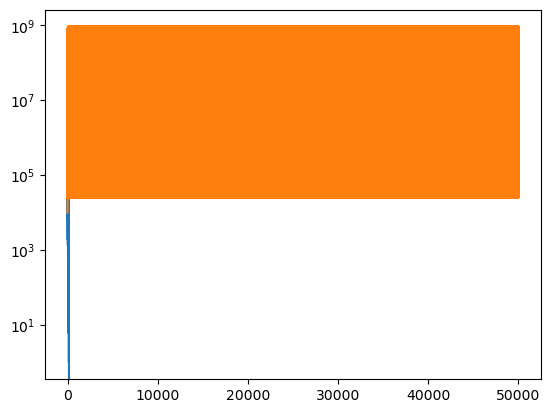

In [14]:
t_fin=1000000
plt.semilogy(frac[:t_fin,0], frac[:t_fin,1])
plt.semilogy(frac[:t_fin,0], frac[:t_fin,2])